<a href="https://colab.research.google.com/github/313kris/two.avogadro.cc/blob/main/Yhillsproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import shap

In [5]:
# Original URL which is giving error as per traceback
# url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/Telco-Customer-Churn.csv'
# Corrected URL obtained from the dataset link given in dataset page in Kaggle.
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
data = pd.read_csv(url)

In [6]:
# Display the first few rows of the dataset
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
# Checking for missing values
print("Missing values:")
print(data.isnull().sum())


Missing values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [10]:
# Dropping customerID column
data.drop(['customerID'], axis=1, inplace=True, errors='ignore')

In [11]:
# Converting TotalCharges to numeric, handling errors
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Filling missing TotalCharges with median
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

<ipython-input-11-cd225cea11f5>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


In [12]:
# Encoding categorical variables using LabelEncoder
label_enc = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    if col != 'Churn':
        data[col] = label_enc.fit_transform(data[col])

# Converting 'Churn' to binary
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

# Splitting features and target
X = data.drop(['Churn'], axis=1)
y = data['Churn']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# Encoding categorical variables using LabelEncoder
label_enc = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    if col != 'Churn':
        data[col] = label_enc.fit_transform(data[col])

# Converting 'Churn' to binary using a more robust approach
# This will ensure all values of 'Churn' are handled correctly
data['Churn'] = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Splitting features and target
X = data.drop(['Churn'], axis=1)
y = data['Churn']

# Now you can split the data without encountering the error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Added stratify=y

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


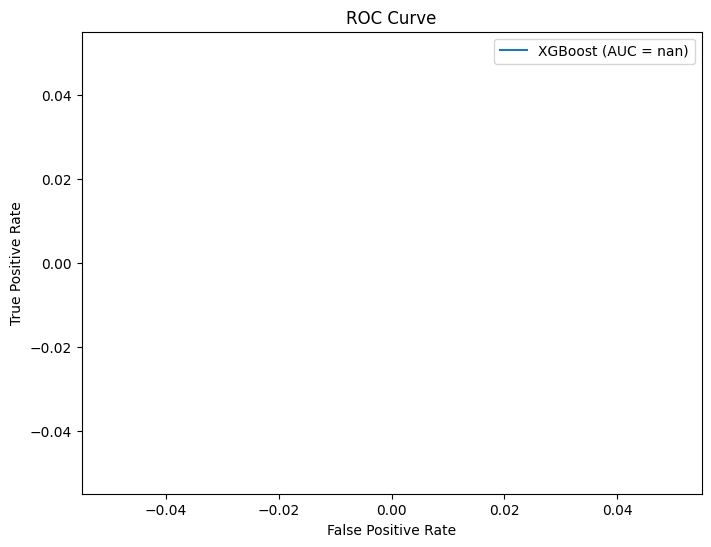

In [18]:
# ROC Curve for XGBoost
xgb_model = XGBClassifier().fit(X_train, y_train)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (AUC = %.2f)' % roc_auc_score(y_test, y_pred_proba))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

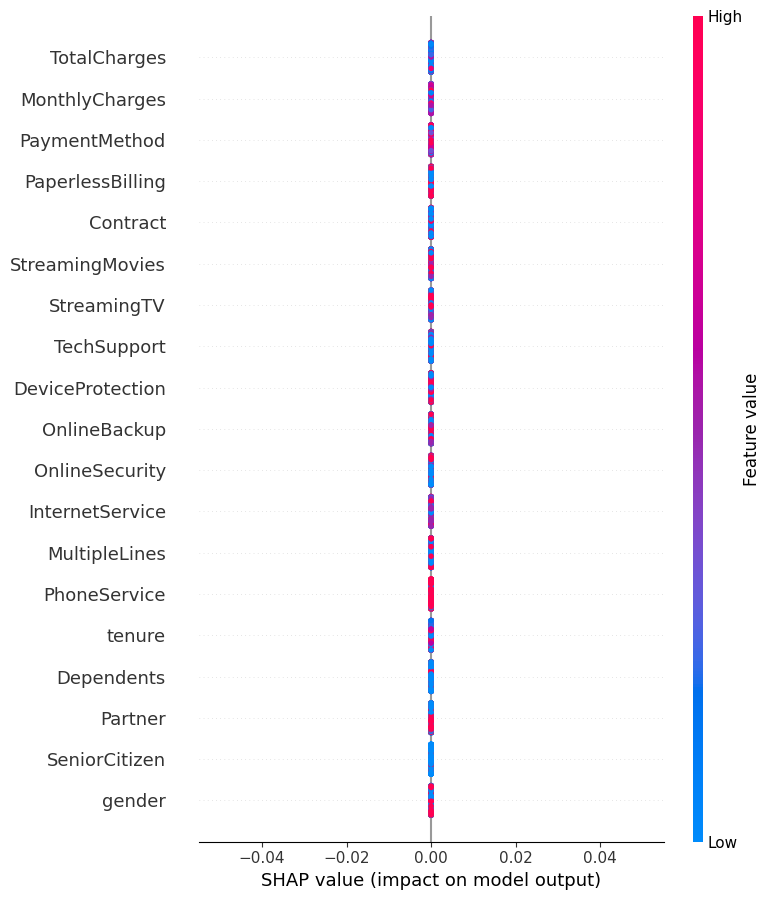

In [21]:
# SHAP Interpretation
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
